## Import & Data Load

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/HD1')


Mounted at /content/drive


In [5]:
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## Data Pre-processing

In [6]:
train = train.drop(columns=['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])
test = test.drop(columns=['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])

In [3]:
!pip install optuna category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [7]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)



X = train.drop(columns=['CI_HOUR'])
y = train['CI_HOUR']

#Target Category
from category_encoders.target_encoder import TargetEncoder

cat_cols = X.select_dtypes(include='object').columns.tolist()

enc=TargetEncoder()
for col in cat_cols:
  X[col] = enc.fit_transform(X[col],y)
  test[col] = enc.transform(test[col])

# 결측치 처리
X.fillna(X.mean(), inplace=True)
test.fillna(X.mean(), inplace=True)

In [8]:
X

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,SHIPMANAGER,FLAG,ATA_LT,PORT_SIZE,year,month,day,hour,minute,weekday
0,109.031581,109.031581,39.811365,30.881018,67.617357,30.0,24,24300,10.0,10.0,...,38.647711,64.873071,5,0.002615,2018,12,17,21,29,0
1,50.338203,64.678644,79.357251,0.000000,53.007093,30.0,13,35900,10.0,10.0,...,97.166903,71.262264,12,0.000217,2014,9,23,6,59,1
2,46.104469,55.686871,39.811365,0.000000,24.501695,50.0,12,146000,30.0,20.0,...,79.036670,64.500805,6,0.001614,2015,2,3,22,0,1
3,42.956832,45.561169,39.811365,0.000000,10.206132,20.0,18,6910,10.0,10.0,...,30.551237,54.749401,13,0.000356,2020,1,17,4,2,4
4,109.031581,109.031581,39.811365,27.037650,38.046830,50.0,10,116000,20.0,10.0,...,33.454474,68.482039,15,0.002615,2020,1,26,7,51,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,42.956832,19.513979,39.811365,0.000000,20.507484,20.0,27,6820,10.0,10.0,...,17.404066,61.773755,14,0.000552,2017,6,6,5,2,1
391935,109.031581,109.031581,79.357251,5.884603,251.951799,10.0,12,3160,10.0,10.0,...,251.951799,77.495206,8,0.002615,2019,10,16,0,36,2
391936,64.388618,54.982687,79.357251,70.660241,63.396749,30.0,8,60300,20.0,10.0,...,43.071997,57.271856,18,0.000155,2021,3,23,22,35,1
391937,22.435063,23.272262,39.811365,9.448179,18.632049,30.0,29,23800,10.0,10.0,...,15.871305,41.074514,15,0.000990,2015,1,8,7,15,3


## 모델 학습 및 특성 중요도 확인

In [9]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.4 MB/s eta 0:00:00


In [10]:
from catboost import CatBoostRegressor

Model Tune for cat.
Learning rate set to 0.105174
0:	learn: 166.3811474	total: 120ms	remaining: 1m 59s
1:	learn: 162.6958897	total: 186ms	remaining: 1m 32s
2:	learn: 159.4636811	total: 255ms	remaining: 1m 24s
3:	learn: 156.8839794	total: 317ms	remaining: 1m 18s
4:	learn: 154.7073952	total: 397ms	remaining: 1m 18s
5:	learn: 152.8635286	total: 470ms	remaining: 1m 17s
6:	learn: 151.2645887	total: 533ms	remaining: 1m 15s
7:	learn: 150.0049866	total: 594ms	remaining: 1m 13s
8:	learn: 148.8500583	total: 661ms	remaining: 1m 12s
9:	learn: 147.8941122	total: 728ms	remaining: 1m 12s
10:	learn: 147.0745088	total: 789ms	remaining: 1m 10s
11:	learn: 146.3535216	total: 851ms	remaining: 1m 10s
12:	learn: 145.7190536	total: 919ms	remaining: 1m 9s
13:	learn: 145.1587383	total: 983ms	remaining: 1m 9s
14:	learn: 144.7394383	total: 1.04s	remaining: 1m 8s
15:	learn: 144.3319160	total: 1.11s	remaining: 1m 8s
16:	learn: 143.8646587	total: 1.18s	remaining: 1m 8s
17:	learn: 143.4765717	total: 1.27s	remaining: 

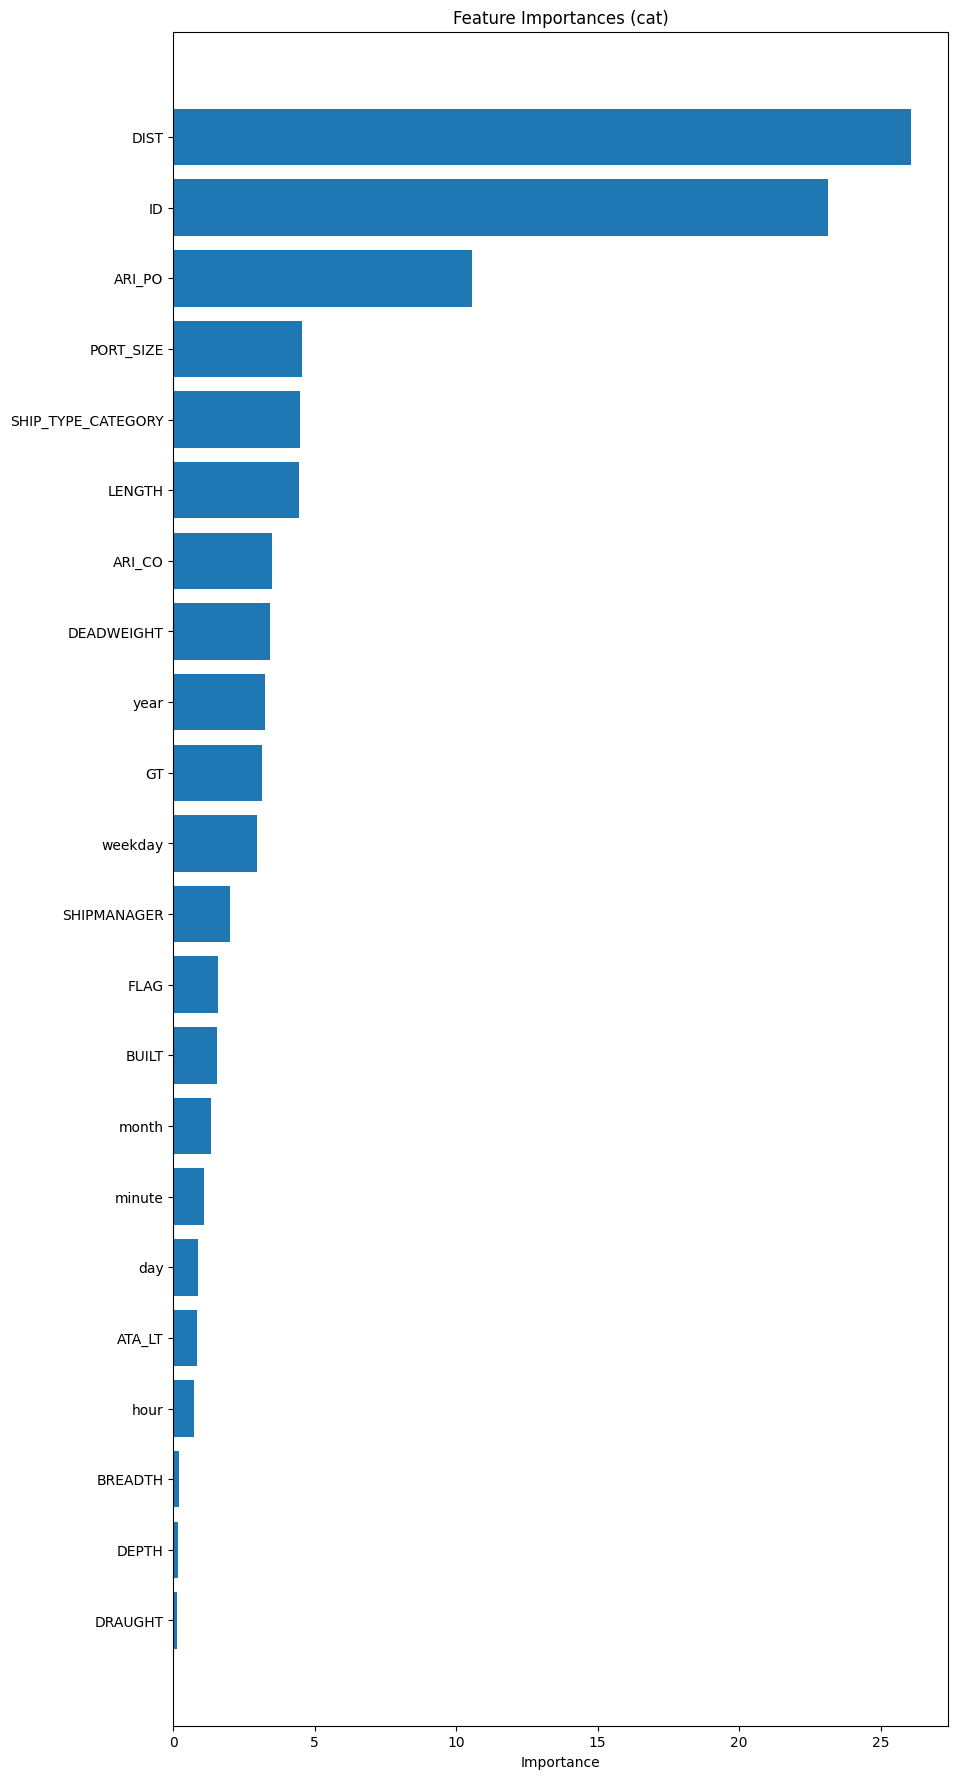

In [11]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

lgbm_model, lgbm_feature_importances = train_and_evaluate(CatBoostRegressor(random_state=42), 'cat', X, y)

## 특성 중요도로부터 Feature Selection

In [12]:
threshold = 2.5# Your Threshold
low_importance_features = X.columns[lgbm_feature_importances < threshold]

X_train_reduced = X.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [14]:
#X_train_reduced = X_train_reduced.drop(columns=['ID', 'SHIPMANAGER', 'FLAG'])
#X_test_reduced = X_test_reduced.drop(columns=['ID', 'SHIPMANAGER', 'FLAG'])
X_train_reduced = X_train_reduced.drop(columns=['ID'])
X_test_reduced = X_test_reduced.drop(columns=['ID'])

In [15]:
X_train_reduced

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,LENGTH,PORT_SIZE,year,weekday
0,109.031581,109.031581,39.811365,30.881018,24300,16700,180.0,0.002615,2018,0
1,50.338203,64.678644,79.357251,0.000000,35900,23500,180.0,0.000217,2014,1
2,46.104469,55.686871,39.811365,0.000000,146000,140000,370.0,0.001614,2015,1
3,42.956832,45.561169,39.811365,0.000000,6910,5400,120.0,0.000356,2020,4
4,109.031581,109.031581,39.811365,27.037650,116000,96600,300.0,0.002615,2020,6
...,...,...,...,...,...,...,...,...,...,...
391934,42.956832,19.513979,39.811365,0.000000,6820,4820,110.0,0.000552,2017,1
391935,109.031581,109.031581,79.357251,5.884603,3160,1600,80.0,0.002615,2019,2
391936,64.388618,54.982687,79.357251,70.660241,60300,34800,200.0,0.000155,2021,1
391937,22.435063,23.272262,39.811365,9.448179,23800,16900,170.0,0.000990,2015,3


In [16]:
X_test_reduced

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,GT,LENGTH,PORT_SIZE,year,weekday
0,109.031581,109.031581,39.811365,1.826589,117000,109000,340.0,0.002615,2020,3
1,46.104469,33.907301,74.744934,25.399386,3810,2560,80.0,0.001028,2021,2
2,46.104469,42.903056,39.811365,111.079467,10900,8440,140.0,0.001743,2019,0
3,77.614549,81.407752,79.357251,9.175258,55800,31500,190.0,0.000182,2015,0
4,42.956832,19.513979,39.811365,0.000000,39800,33000,220.0,0.000552,2018,2
...,...,...,...,...,...,...,...,...,...,...
220486,166.406278,180.061534,79.357251,21.712733,298000,151000,330.0,0.000080,2017,1
220487,77.614549,86.712836,79.357251,4.870490,80500,42700,220.0,0.000039,2016,0
220488,42.956832,67.539772,76.389456,17.068286,1200,500,60.0,0.000264,2022,6
220489,46.104469,42.698292,74.744934,0.000000,3420,2000,80.0,0.000595,2020,0


In [17]:
X_train_reduced['year'] = X_train_reduced['year'] - 2014

In [18]:
X_test_reduced['year'] = X_test_reduced['year'] - 2014

In [ ]:
#X_train_reduced['month'] = X_train_reduced['month'] - 1
#X_test_reduced['month'] = X_test_reduced['month'] - 1

In [ ]:
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetRegressor

In [25]:
clf = TabNetRegressor( cat_emb_dim=10,optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=1e-2)
)
#원래 범주형 변수 지정을 해줘야하는데 생략함
test_X = X_test_reduced.values
test_X = torch.from_numpy(test_X)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y[train_idx], y[val_idx]
    X_t, X_val, y_t, y_val = X_t.values, X_val.values, y_t.values, y_val.values
    y_t = y_t.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    # 두 모델 모두 학습
    max_epochs = 15

    clf.fit(
        X_train=X_t, y_train=y_t,
        eval_set=[(X_val, y_val)],
        eval_name=['valid'],
        eval_metric=['mae'],
        max_epochs=max_epochs , patience=20,
                  # use binary cross entropy as this is not a regression problem
      loss_fn=torch.nn.functional.l1_loss
    )

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = clf.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = clf.predict(test_X)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 0  | loss: 51.17176| valid_mae: 48.52176|  0:00:41s
epoch 1  | loss: 49.16304| valid_mae: 47.67599|  0:01:00s
epoch 2  | loss: 48.8287 | valid_mae: 47.52201|  0:01:19s
epoch 3  | loss: 48.66674| valid_mae: 47.4222 |  0:01:38s
epoch 4  | loss: 48.52838| valid_mae: 47.67065|  0:02:03s
epoch 5  | loss: 48.47091| valid_mae: 47.27774|  0:02:23s
epoch 6  | loss: 48.43644| valid_mae: 47.23668|  0:02:43s
epoch 7  | loss: 48.38497| valid_mae: 47.26984|  0:03:02s
epoch 8  | loss: 48.35669| valid_mae: 47.22316|  0:03:22s
epoch 9  | loss: 48.36142| valid_mae: 47.42096|  0:03:42s
epoch 10 | loss: 48.35512| valid_mae: 47.26119|  0:04:03s
epoch 11 | loss: 48.29033| valid_mae: 47.14964|  0:04:22s
epoch 12 | loss: 48.29701| valid_mae: 50.20365|  0:04:43s
epoch 13 | loss: 48.25701| valid_mae: 47.15248|  0:05:02s
epoch 14 | loss: 48.23433| valid_mae: 47.1142 |  0:05:21s
Stop training because you reached max_epochs = 15 with best_epoch = 14 and best_valid_mae = 47.1142


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Processing folds:  20%|██        | 1/5 [05:51<23:24, 351.07s/it]

epoch 0  | loss: 50.57149| valid_mae: 49.21419|  0:00:22s
epoch 1  | loss: 48.37197| valid_mae: 48.65633|  0:00:43s
epoch 2  | loss: 48.14265| valid_mae: 48.63237|  0:01:04s
epoch 3  | loss: 48.03114| valid_mae: 48.80733|  0:01:25s
epoch 4  | loss: 47.92116| valid_mae: 48.47472|  0:01:44s
epoch 5  | loss: 47.88764| valid_mae: 48.40309|  0:02:05s
epoch 6  | loss: 47.84195| valid_mae: 48.43109|  0:02:25s
epoch 7  | loss: 47.78903| valid_mae: 48.39405|  0:02:45s
epoch 8  | loss: 47.72464| valid_mae: 48.35555|  0:03:05s
epoch 9  | loss: 47.71199| valid_mae: 48.66901|  0:03:27s
epoch 10 | loss: 47.68809| valid_mae: 48.25082|  0:03:48s
epoch 11 | loss: 47.63907| valid_mae: 48.247  |  0:04:08s
epoch 12 | loss: 47.64903| valid_mae: 49.81105|  0:04:31s
epoch 13 | loss: 47.59602| valid_mae: 48.25244|  0:04:51s
epoch 14 | loss: 47.58445| valid_mae: 48.40503|  0:05:10s
Stop training because you reached max_epochs = 15 with best_epoch = 11 and best_valid_mae = 48.247


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Processing folds:  40%|████      | 2/5 [11:18<16:50, 337.00s/it]

epoch 0  | loss: 50.78876| valid_mae: 49.45905|  0:00:18s
epoch 1  | loss: 48.60755| valid_mae: 48.96197|  0:00:37s
epoch 2  | loss: 48.17191| valid_mae: 48.62954|  0:00:57s
epoch 3  | loss: 48.04114| valid_mae: 48.70031|  0:01:16s
epoch 4  | loss: 48.05003| valid_mae: 48.46858|  0:01:36s
epoch 5  | loss: 47.98813| valid_mae: 48.48511|  0:01:55s
epoch 6  | loss: 47.87554| valid_mae: 48.5762 |  0:02:14s
epoch 7  | loss: 47.80589| valid_mae: 50.82161|  0:02:32s
epoch 8  | loss: 47.79723| valid_mae: 51.62165|  0:02:51s
epoch 9  | loss: 47.75219| valid_mae: 48.37377|  0:03:10s
epoch 10 | loss: 47.71747| valid_mae: 52.2479 |  0:03:29s
epoch 11 | loss: 47.73059| valid_mae: 48.46546|  0:03:48s
epoch 12 | loss: 47.64203| valid_mae: 49.10145|  0:04:07s
epoch 13 | loss: 47.61821| valid_mae: 48.23659|  0:04:28s
epoch 14 | loss: 47.59636| valid_mae: 48.70179|  0:04:48s
Stop training because you reached max_epochs = 15 with best_epoch = 13 and best_valid_mae = 48.23659


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Processing folds:  60%|██████    | 3/5 [16:23<10:45, 322.69s/it]

epoch 0  | loss: 50.63342| valid_mae: 48.45841|  0:00:19s
epoch 1  | loss: 48.45519| valid_mae: 48.0052 |  0:00:38s
epoch 2  | loss: 48.2765 | valid_mae: 48.00425|  0:00:56s
epoch 3  | loss: 48.14263| valid_mae: 47.91722|  0:01:15s
epoch 4  | loss: 48.08662| valid_mae: 47.78127|  0:01:34s
epoch 5  | loss: 48.0517 | valid_mae: 47.81135|  0:01:53s
epoch 6  | loss: 47.99383| valid_mae: 47.72293|  0:02:12s
epoch 7  | loss: 47.92677| valid_mae: 47.66907|  0:02:31s
epoch 8  | loss: 47.93538| valid_mae: 49.94656|  0:02:51s
epoch 9  | loss: 47.9064 | valid_mae: 48.22707|  0:03:10s
epoch 10 | loss: 47.91373| valid_mae: 47.726  |  0:03:30s
epoch 11 | loss: 47.89382| valid_mae: 50.00402|  0:03:50s
epoch 12 | loss: 47.86083| valid_mae: 47.58135|  0:04:10s
epoch 13 | loss: 47.8545 | valid_mae: 47.57172|  0:04:33s
epoch 14 | loss: 47.8482 | valid_mae: 47.68003|  0:05:07s
Stop training because you reached max_epochs = 15 with best_epoch = 13 and best_valid_mae = 47.57172


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Processing folds:  80%|████████  | 4/5 [21:54<05:25, 325.98s/it]

epoch 0  | loss: 51.35627| valid_mae: 48.75417|  0:00:27s
epoch 1  | loss: 49.01705| valid_mae: 48.23166|  0:00:47s
epoch 2  | loss: 48.5963 | valid_mae: 47.87871|  0:01:10s
epoch 3  | loss: 48.45125| valid_mae: 48.3088 |  0:01:31s
epoch 4  | loss: 48.28146| valid_mae: 47.61048|  0:01:51s
epoch 5  | loss: 48.19655| valid_mae: 47.64902|  0:02:10s
epoch 6  | loss: 48.12175| valid_mae: 47.60229|  0:02:29s
epoch 7  | loss: 48.0008 | valid_mae: 47.33727|  0:02:48s
epoch 8  | loss: 47.97196| valid_mae: 47.44749|  0:03:08s
epoch 9  | loss: 47.86494| valid_mae: 47.1933 |  0:03:28s
epoch 10 | loss: 47.80474| valid_mae: 46.97563|  0:03:49s
epoch 11 | loss: 47.71627| valid_mae: 47.21296|  0:04:10s
epoch 12 | loss: 47.65754| valid_mae: 46.71071|  0:04:30s
epoch 13 | loss: 47.61143| valid_mae: 46.57194|  0:04:50s
epoch 14 | loss: 47.40432| valid_mae: 48.64684|  0:05:10s
Stop training because you reached max_epochs = 15 with best_epoch = 13 and best_valid_mae = 46.57194


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Processing folds: 100%|██████████| 5/5 [27:27<00:00, 329.54s/it]

Validation : MAE scores for each fold: [47.11419724364188, 48.246996046962614, 48.23659378993167, 47.571719294873645, 46.57193530386186]
Validation : MAE: 47.54828833585434


## Submission

In [26]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit_DACON.csv', index=False)

In [27]:
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,0.892560
1,TEST_000001,20.458673
2,TEST_000002,25.973745
3,TEST_000003,49.922615
4,TEST_000004,0.003954
...,...,...
220486,TEST_220486,109.099472
220487,TEST_220487,42.425720
220488,TEST_220488,46.113544
220489,TEST_220489,0.005620
